In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import networkx as nx

Notation: 
* SF = scale free
* ER = Erdosh Renyi

In [2]:
### PARAMETERS ###
N = 1000
k0 = 2
p_mob = 0.05
eps = 0.1 # not implemented
beta = 0.09
mu = 0.05 
gamma = 0.01

In [3]:
# barabasi-albert is a preferential attachment network (with power law degree)
G_sf = nx.barabasi_albert_graph(N,k0) #number of nodes, number of links added for each node
mean_deg_sf = sum([k for i, k in G_sf.degree()])/len(G_sf.degree())
print("K0: \t", k0)
print("Kmean: ", mean_deg_sf)

K0: 	 2
Kmean:  3.992


In [4]:
p = k0/N*2 # prob of creating an edge
G_er = nx.binomial_graph(N,p) # Erdosh-Renyi graph
mean_deg_er = sum([k for i, k in G_er.degree()])/len(G_er.degree())
print("Kmean: ", mean_deg_er)

Kmean:  4.082


In [23]:
n_er = np.array(list(G_er.degree()))
mask = (n_er[:,1] > 0)
node_list = n_er[mask, 0]

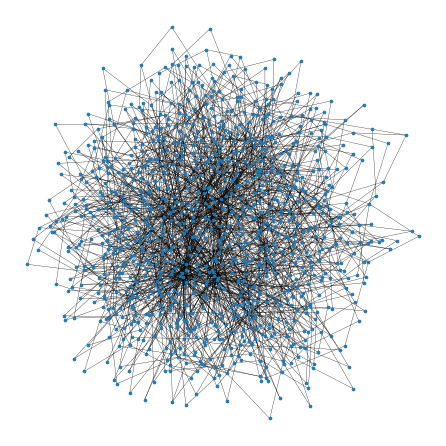

In [26]:
plt.figure(figsize=(6,6))
nx.draw(G_sf, node_size = 7, width = 0.3)

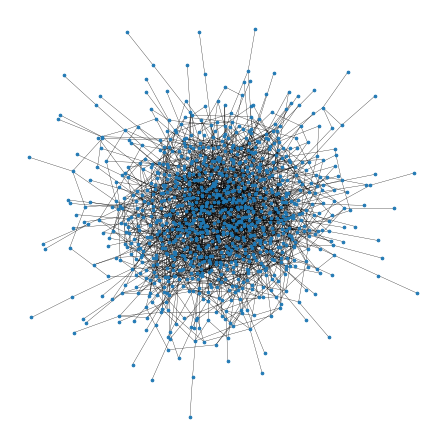

In [27]:
plt.figure(figsize=(6,6))
nx.draw(G_er, node_size = 7, width = 0.3, nodelist=list(node_list))

Now we get the adjacency matrices

In [5]:
A_sf = nx.to_numpy_matrix(G_sf)
A_er = nx.to_numpy_matrix(G_er)

In [6]:
def SIRS_step(A, state, beta, mu, gamma, T=0.5, debug=False):
    """
    SIRS step for a single network. Updated A and state needs to be computed
    before calling this function (take into account mobility + dynamic contacts).
    Works with synchronous update (e.g. new infected cannot recover in this step).
    
    Parameters
    ----------
    - A : adjacency matrix
    - state : 
        state[:,0] = 1 for the susceptible, 0 for the others
        state[:,1] = 1 for the infected, 0 for the others
        state[:,2] = 1 for the recovered, 0 for the others
    - beta : prob of infection given contact
    - mu : prob of recovery per step
    - gamma : prob of S->R transition per step
    - T : fraction of the day spent in the system
    
    Return
    ------
    state, recovered (updated)
    """
    N = len(state)
    new_state = np.zeros((N,3))
    
    # print function that works only if debug=True
    dprint = print if debug else lambda *args, **kwargs : None
        
    ### S -> I ###
    p_I = beta*np.matmul(A,state[:,1]).T # prob of getting the infection
    p_I = np.array(p_I).reshape(N) # issues with matmul that outputs a matrix instead of an array
    u = np.random.rand(N) 
    mask_S = (u < p_I*state[:,0]) # apply only to susceptible
    new_state[mask_S,1] = 1 # register new infected -> they cannot recover in this step
    state[mask_S,0] = 0 # remove infected susceptible
    
    dprint("New I: ", new_state[:,1].sum())
    
    ### I -> R ###
    u = np.random.rand(N) 
    mask_I = (u < mu*state[:,1]) # apply only to infected
    new_state[mask_I,2] = 1 # register new recovered -> they cannot become susceptible in this step
    state[mask_I,1] = 0 # remove recovered infected
    
    dprint("New R: ", new_state[:,2].sum())
    
    ### R -> S ###
    u = np.random.rand(N) 
    mask_R = (u < gamma*state[:,2]) # apply only to recovered
    new_state[mask_R,0] = 1 # register new susceptible
    state[mask_R,2] = 0 # remove old recovered
    
    dprint("New S: ", new_state[:,0].sum())
    
    state = state + new_state # update the old state
    
    dprint("Updated S: ", state[:,0].sum())
    dprint("Updated I: ", state[:,1].sum())
    dprint("Updated R: ", state[:,2].sum())
    
    return state

Comments: the computation for the probability of getting infected works only at the beginning of the infection, then it overestimates the infection strength.

One can try to approximate it better, but the difficult thing is to do it in an efficient way.

In [7]:
# TEST
N = 1000
I0 = 5 # initial number of infected

G_test = nx.barabasi_albert_graph(N,4)
A_test = nx.to_numpy_matrix(G_test)

# prepare initial state
def prepare_init_state(N, I0):
    """
    Prepare a system of N nodes and I0 infected.
    
    Parameters
    ----------
    N : int, number of nodes
    I0 : int, number of initial infected nodes
    
    Returns
    -------
    state :  numpy array of shape (N,3) 
        state[:,0] = 1 for the susceptible, 0 for the others
        state[:,1] = 1 for the infected, 0 for the others
        state[:,2] = 1 for the recovered, 0 for the others
    """
    susceptible = np.ones(N)
    seeds = np.random.choice(np.arange(N), size = I0)
    susceptible[seeds] = 0
    state = np.zeros((N,3))
    state[:,0] = susceptible
    state[seeds,1] = 1
    return state

state = prepare_init_state(N,I0)

In [8]:
import time 
start = time.time()
n_iter = 200
S = []
I = []
R = []
t_vec = []
for i in range(n_iter):
    state = SIRS_step(A_test, state, beta, mu, gamma, T=1, debug=False)
    S.append(state[:,0].sum())
    I.append(state[:,1].sum())
    R.append(state[:,2].sum())
    t_vec.append(time.time()-start)
tot_time = time.time()-start
print("Total time elapsed: %.2f s"%tot_time)
print("Time per iteration: %.4f s"%(tot_time/n_iter))
S = np.array(S)
I = np.array(I)
R = np.array(R)
t_vec = np.array(t_vec)

Total time elapsed: 0.37 s
Time per iteration: 0.0018 s


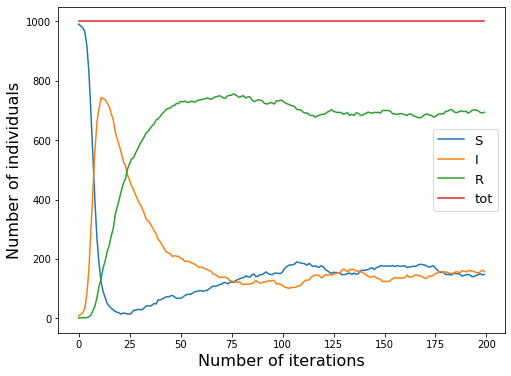

In [9]:
indexes = np.arange(n_iter)
plt.figure(figsize=(8,6))
plt.plot(indexes, S, label = 'S')
plt.plot(indexes, I, label = 'I')
plt.plot(indexes, R, label = 'R')
plt.plot(indexes, S+I+R, label = 'tot')
plt.xlabel('Number of iterations', fontsize = 16)
plt.ylabel('Number of individuals', fontsize = 16)
plt.legend(fontsize=13)
plt.show()

## Commuting over networks

Simplifying assumptions:
* $N_i = N_j$
* $N_{ij} = N_{ji} $

In [10]:
Nij = int(p_mob*N)
print("Number of individuals travelling from each network: ", Nij)
N_tot = N + Nij # same for the two networks

Number of individuals travelling from each network:  50


In [11]:
travellers_sf = np.random.choice(np.arange(N), size=Nij, replace=False)
travellers_er = np.random.choice(np.arange(N), size=Nij, replace=False)

# this travellers will be numbered starting from N when they are at work 
#(but we need to know what are their identities in the original system)
new_ids_sf = {} # fixed for the entire simulation ! (no need for performance)
for i, ID in enumerate(travellers_sf):
    new_ids_sf[i+N] = ID
new_ids_er = {} # fixed for the entire simulation ! (no need for performance)
for i, ID in enumerate(travellers_er):
    new_ids_er[i+N] = ID

Now we focus on obtaining the network without the travellers

In [12]:
mob_mask_sf = np.isin(np.arange(N), travellers_sf)
A_sf_stay = np.copy(A_sf)
A_sf_stay[mob_mask_sf,:] = 0
A_sf_stay[:,mob_mask_sf] = 0
G_sf_stay = nx.from_numpy_matrix(A_sf_stay)

mob_mask_er = np.isin(np.arange(N), travellers_er)
A_er_stay = np.copy(A_er)
A_er_stay[mob_mask_er,:] = 0
A_er_stay[:,mob_mask_er] = 0
G_er_stay = nx.from_numpy_matrix(A_er_stay)

Now we need to get the degrees of the travellers, because we assume that they will form the same number of connections also in the other network (approximately).

In [13]:
deg_sf = [k for n,k in G_sf.degree(travellers_sf)]
deg_er = [k for n,k in G_sf.degree(travellers_er)]

In [14]:
def attach_travellers(G_sf_stay, new_ids_er, deg_er, N_tot):
    """
    Attach new travellers using preferential attachment and keeping their original degrees.
    
    Parameters
    ----------
    G_sf_stay : networkx Graph instance, graph of the nodes that do not travel
    new_ids_er :  dict, contains the pairs {'new_id_er':old_id}
    deg_er :  numpy array of int, contains the degrees of all the travelling nodes from the ER network
    N_tot : int, number of original nodes + travelling nodes
    
    Returns
    -------
    G_sf_day :  networkx Graph instance, graph of the nodes that stay in the SF system 
                + those that come from the ER network
    A_sf_day : numpy matrix, adjacency matrix of G_sf_day 
    """
    edge_list_sf = list(G_sf_stay.edges)
    for i,ID in enumerate(new_ids_er.keys()):
        k = deg_er[i]
        indexes = np.random.choice(len(edge_list_sf), size=k, replace=False)
        #targets = []
        for j in indexes:
            trg = np.random.choice(list(edge_list_sf[j]))
            #if trg in targets:
            edge_list_sf.append((ID,trg))
            
    G_sf_day = nx.Graph(edge_list_sf)
    # add also the nodes without edges to get the known dimension N_tot
    G_sf_day.add_nodes_from(np.arange(N_tot))
    A_sf_day = nx.to_numpy_matrix(G_sf_day, nodelist=np.arange(N_tot))
    
    return G_sf_day, A_sf_day

Note: in this function it can happen that the same node is chosen more than once from the same travellers. This implies that sometimes there are less connections than expected and this happens very frequently with the nodes with higher degree. Also it can happen that they increase their number of connections because some other traveller chooses to connect with them! 

Also there is to implement the random attachment instead of the preferential one, where you pick directly a node at random between those that stay in the system (this needs to be checked, so you will need also the travellers from the system to check the departures).

In [15]:
# call the function
G_sf_day, _ = attach_travellers(G_sf_stay, new_ids_er, deg_er, N_tot)

In [16]:
### just for debugging purposes ###

real_deg = G_sf_day.degree(new_ids_er.keys())

for i,k in enumerate(deg_er):
    print("Original vs real degree: %d\t%d"%(k,real_deg[i+N])) 

Original vs real degree: 5	4
Original vs real degree: 2	2
Original vs real degree: 2	2
Original vs real degree: 3	3
Original vs real degree: 2	2
Original vs real degree: 2	2
Original vs real degree: 2	2
Original vs real degree: 6	6
Original vs real degree: 12	12
Original vs real degree: 4	4
Original vs real degree: 2	2
Original vs real degree: 2	2
Original vs real degree: 3	4
Original vs real degree: 3	3
Original vs real degree: 2	2
Original vs real degree: 2	2
Original vs real degree: 2	2
Original vs real degree: 5	5
Original vs real degree: 13	13
Original vs real degree: 7	7
Original vs real degree: 2	2
Original vs real degree: 3	3
Original vs real degree: 4	5
Original vs real degree: 2	2
Original vs real degree: 4	4
Original vs real degree: 2	2
Original vs real degree: 2	2
Original vs real degree: 4	4
Original vs real degree: 2	2
Original vs real degree: 2	2
Original vs real degree: 2	2
Original vs real degree: 2	2
Original vs real degree: 2	2
Original vs real degree: 2	2
Original v

In [17]:
# how to get the adjacency matrix from the graph
A_sf_day = nx.to_numpy_matrix(G_sf_day, nodelist=np.arange(N_tot))

# debug 
A_sf_day[1000,:].sum() # real degree of the first traveller (see cell above)

4.0

Extracting the state of the travellers 

In [18]:
# prepare states just for trying things
state_sf = prepare_init_state(N,I0)
state_er = prepare_init_state(N,I0)

In [19]:
state_sf_trav = state_sf[travellers_sf]
print("state_sf_trav.shape: ", state_sf_trav.shape)
state_er_trav = state_er[travellers_er]

# then concatenate them during the "day"
state_sf_day = np.concatenate((state_sf, state_er_trav))
print("state_sf_day.shape: ", state_sf_day.shape)
state_er_day = np.concatenate((state_er, state_sf_trav))

# we also need masks to cancel the contribution of the people that are not in the system during the day
# we already done that before, but for range N instead of N_tot

mob_mask_sf = (~np.isin(np.arange(N_tot), travellers_sf)).astype(int)
print("mob_mask_sf.shape: ", mob_mask_sf.shape)
mob_mask_er = (~np.isin(np.arange(N_tot), travellers_er)).astype(int)

state_sf_trav.shape:  (50, 3)
state_sf_day.shape:  (1050, 3)
mob_mask_sf.shape:  (1050,)


Now we need to modify the SIRS dynamics masking out the absent people. This should work for the day, whereas for the night we simply use the original system.

In [20]:
state = state_sf_day
masked_susceptible = state[:,1]*mob_mask_sf

In [21]:
print("Indices of the travellers: \n", travellers_sf)
print("Indices of the infected: \n", np.where(state[:,1] == 1))
# 0 means that the infected is not present in the system
print("Infected present in the system: \n", masked_susceptible[np.where(state[:,1] == 1)]) 

Indices of the travellers: 
 [993 897  63 132 753 216  19 660 100 872 375 974 488 329  32 459 479 877
 636 779 849 864 170 922 551 917  92  30 599  59 865 516  91 668 530 150
 691 842  88 331  69 552  66 423 305  84 102 420 537  23]
Indices of the infected: 
 (array([ 207,  242,  304,  470,  492, 1040]),)
Infected present in the system: 
 [1. 1. 1. 1. 1. 1.]


The idea is that the only passage where we need to mask the absent infected is where we compute the interaction term between susceptible and infected. For the I->R and R->S transitions we can consider the travellers virtually present for the sake of simplicity and just overwrite their state with the correct one obtained from the other system (because they are present as travellers there in the meantime).

In [22]:
def SIRS_masked_step(A, state, mask, beta, mu, gamma, T=0.5, debug=False):
    """
    SIRS step for a single network. Updated A and state needs to be computed
    before calling this function (take into account mobility + dynamic contacts).
    Works with synchronous update (e.g. new infected cannot recover in this step).
    
    Parameters
    ----------
    - A : adjacency matrix
    - state : 
        state[:,0] = 1 for the susceptible, 0 for the others
        state[:,1] = 1 for the infected, 0 for the others
        state[:,2] = 1 for the recovered, 0 for the others
    - mask : True at index i if that node is present in the system at current step
    - beta : prob of infection given contact
    - mu : prob of recovery per step
    - gamma : prob of S->R transition per step
    - T : fraction of the day spent in the system
    
    Return
    ------
    state, recovered (updated)
    """
    N = len(state)
    new_state = np.zeros((N,3))
    
    dprint = print if debug else lambda *args, **kwargs : None
        
    ### S -> I ###
    p_I = beta*np.matmul(A,state[:,1]*mask).T # prob of getting the infection
    p_I = np.array(p_I).reshape(N)
    u = np.random.rand(N) 
    mask_S = (u < p_I*state[:,0]) # apply only to susceptible
    new_state[mask_S,1] = 1
    state[mask_S,0] = 0
    
    dprint("New I: ", new_state[:,1].sum())
    
    ### I -> R ###
    u = np.random.rand(N) 
    mask_I = (u < mu*state[:,1]) # apply only to infected
    new_state[mask_I,2] = 1
    state[mask_I,1] = 0
    
    dprint("New R: ", new_state[:,2].sum())
    
    ### R -> S ###
    u = np.random.rand(N) 
    mask_R = (u < gamma*state[:,2]) # apply only to recovered
    new_state[mask_R,0] = 1
    state[mask_R,2] = 0
    
    dprint("New S: ", new_state[:,0].sum())
    
    state = state + new_state
    
    dprint("Updated S: ", state[:,0].sum())
    dprint("Updated I: ", state[:,1].sum())
    dprint("Updated R: ", state[:,2].sum())
    
    return state

In [23]:
def two_sys_full_SIRS_step(state_sf, state_er, travellers_sf, travellers_er, new_ids_sf, new_ids_er, 
                           deg_sf, deg_er, A_sf, A_er, G_sf_stay, G_er_stay, beta, mu, gamma):
    """ 
    Simulate a single step of a SIRS dynamics over 2 coupled network with mobility, 
    taking into account the undelying structure of the networks. 
    
    Parameters
    ----------
    state_sf: numpy array of shape (N,3) - state of the scale free network
        state_sf[:,0] = 1 for the susceptible, 0 for the others
        state_sf[:,1] = 1 for the infected, 0 for the others
        state_sf[:,2] = 1 for the recovered, 0 for the others
    state_er: numpy array of shape (N,3) - state of the Erdosh-Renyi network
    **variables_net_sf (see "prepare_two_sys" function description)
    **variables_net_er (see "prepare_two_sys" function description)
    **infection_params (beta, mu, gamma)
    
    Returns
    -------
    state_sf, state_er (updated)
    """
    N = len(state_sf)
    Nij = len(travellers_sf)
    N_tot = N + Nij
    
    ### day ###
    
    # compute day networks
    _, A_sf_day = attach_travellers(G_sf_stay, new_ids_er, deg_er, N_tot)
    _, A_er_day = attach_travellers(G_er_stay, new_ids_sf, deg_sf, N_tot)
    
    # mobility masks (True if present, False if travelling)
    mob_mask_sf = (~np.isin(np.arange(N_tot), travellers_sf)).astype(int)
    mob_mask_er = (~np.isin(np.arange(N_tot), travellers_er)).astype(int)
    
    # states of the travellers
    state_sf_trav = state_sf[travellers_sf]
    state_er_trav = state_er[travellers_er]

    # stay + travellers of the other system state 
    # also absent travellers are virtually present - that is why we use masks
    state_sf_day = np.concatenate((state_sf, state_er_trav))
    state_er_day = np.concatenate((state_er, state_sf_trav))
    
    # make day SIRS step
    state_sf_day = SIRS_masked_step(A_sf_day, state_sf_day, mob_mask_sf, beta, mu, gamma)
    state_er_day = SIRS_masked_step(A_er_day, state_er_day, mob_mask_er, beta, mu, gamma)
    
    # extract the state of the travellers
    state_sf_trav = state_er_day[N:] 
    state_er_trav = state_sf_day[N:] 

    # overwrite them into the original system 
    state_sf[travellers_sf] = state_sf_trav
    state_er[travellers_sf] = state_er_trav
    
    ### night ###
    
    # make SIRS step
    state_sf = SIRS_step(A_sf, state_sf, beta, mu, gamma)
    state_er = SIRS_step(A_er, state_er, beta, mu, gamma)
    
    return state_sf, state_er

In [25]:
def prepare_two_sys(N, I_sf, I_er, p_mob, mean_degree):
    """ 
    Defines two networks, one with a power law distribution (a.k.a. scale-free distribution),
    the other with random connections (binomial or Erdosh-Renyi graph).
    Defines two initial states, one for each network, containing categorical information about the status
    of each node of the network.
    Computes some variables linked to the mobility between the two networks (commuting), 
    used in the SIRS simulation.
    
    Parameters
    ----------
    N : int, number of nodes of each network
    I_sf : int, number of initial infected in the scale-free network
    I_er : int, number of initial infected in the Erdosh-Renyi network
    p_mob : float, probability that each individual has of being a traveller
    mean_degree : (even) int, mean degree of each network
    
    Returns
    -------
    state_sf : numpy array of shape (N,3) - state of the scale free network
        state_sf[:,0] = 1 for the susceptible, 0 for the others
        state_sf[:,1] = 1 for the infected, 0 for the others
        state_sf[:,2] = 1 for the recovered, 0 for the others
        
    state_er : numpy array of shape (N,3) - state of the Erdosh-Renyi network
    
    variables_net_sf : dict, keys = {'travellers_sf', 'new_ids_sf', 'deg_sf', 'A_sf', 'G_sf_stay'}
        travellers_sf : numpy array of int, contains the IDs of the travelling nodes
        new_ids_sf : dict, contains the pairs {'new_id_sf':old_id}
        deg_sf : numpy array of int, contains the degrees of all the travelling nodes
        A_sf : numpy matrix, adjacency matrix of the scale-free network
        G_sf_stay : networkx Graph instance, graph of the nodes that do not travel
        
    variables_net_er : dict, keys = {'travellers_er', 'new_ids_er', 'deg_er', 'A_er', 'G_er_stay'}
    """
    ### Topology ###
    
    p = mean_degree/N # prob of creating an edge
    
    # create networks
    G_sf = nx.barabasi_albert_graph(N,int(mean_degree/2))
    G_er = nx.binomial_graph(N,p)
    
    # get adjacency matrices
    A_sf = nx.to_numpy_matrix(G_sf)
    A_er = nx.to_numpy_matrix(G_er)
    
    ### Initial state ###
    
    state_sf = prepare_init_state(N,I_sf)
    state_er = prepare_init_state(N,I_er)
    
    ### Mobility part ### 
    
    Nij = int(p_mob*N) # number of travellers for each system
    
    # Choose travellers IDs
    travellers_sf = np.random.choice(np.arange(N), size=Nij, replace=False)
    travellers_er = np.random.choice(np.arange(N), size=Nij, replace=False)
    
    # Map the travellers IDs in the other system as N, N+1,...,N+Nij-1
    new_ids_sf = {} 
    for i, ID in enumerate(travellers_sf):
        new_ids_sf[i+N] = ID
    new_ids_er = {} 
    for i, ID in enumerate(travellers_er):
        new_ids_er[i+N] = ID
        
    # Compute the adjacency matrices and the networks of the remainers
    mob_mask_sf = np.isin(np.arange(N), travellers_sf)
    A_sf_stay = np.copy(A_sf)
    A_sf_stay[mob_mask_sf,:] = 0
    A_sf_stay[:,mob_mask_sf] = 0
    G_sf_stay = nx.from_numpy_matrix(A_sf_stay)

    mob_mask_er = np.isin(np.arange(N), travellers_er)
    A_er_stay = np.copy(A_er)
    A_er_stay[mob_mask_er,:] = 0
    A_er_stay[:,mob_mask_er] = 0
    G_er_stay = nx.from_numpy_matrix(A_er_stay)
    
    # Compute the original degrees of the travellers
    deg_sf = [k for n,k in G_sf.degree(travellers_sf)]
    deg_er = [k for n,k in G_sf.degree(travellers_er)]
    
    # wrap variables in dictionaries 
    variables_net_sf = {'travellers_sf':travellers_sf, 'new_ids_sf':new_ids_sf, 'deg_sf':deg_sf,
                        'A_sf':A_sf, 'G_sf_stay':G_sf_stay }

    variables_net_er = {'travellers_er':travellers_er, 'new_ids_er':new_ids_er, 'deg_er':deg_er,
                        'A_er':A_er, 'G_er_stay':G_er_stay }
    
    return state_sf, state_er, variables_net_sf, variables_net_er

### Test

In [26]:
# parameters
N = 1000
I_sf = 5
I_er = 2
p_mob = 0.05
mean_degree = 4
eps = 0.1
beta = 0.09
mu = 0.08 # change this, it's the most unreasonable estimate
gamma = 0.01

In [27]:
# prepare systems
state_sf, state_er, variables_net_sf, variables_net_er = prepare_two_sys(N, I_sf, I_er, p_mob, mean_degree)

In [28]:
infection_params = dict(beta=beta, mu=mu, gamma=gamma)
infection_params

{'beta': 0.09, 'mu': 0.08, 'gamma': 0.01}

In [29]:
state_sf, state_er = two_sys_full_SIRS_step(state_sf, state_er, **variables_net_sf, 
                                            **variables_net_er, **infection_params)

In [30]:
import time 
start = time.time()
n_iter = 1000
S_sf = []
I_sf = []
R_sf = []
S_er = []
I_er = []
R_er = []
t_vec = []
for i in range(n_iter):
    state_sf, state_er = two_sys_full_SIRS_step(state_sf, state_er, **variables_net_sf, 
                                            **variables_net_er, **infection_params)
    S_sf.append(state_sf[:,0].sum())
    I_sf.append(state_sf[:,1].sum())
    R_sf.append(state_sf[:,2].sum())
    S_er.append(state_er[:,0].sum())
    I_er.append(state_er[:,1].sum())
    R_er.append(state_er[:,2].sum())
    t_vec.append(time.time()-start)
    
tot_time = time.time()-start
print("Total time elapsed: %.2f s"%tot_time)
print("Time per iteration: %.4f s"%(tot_time/n_iter))

S_sf = np.array(S_sf)
I_sf = np.array(I_sf)
R_sf = np.array(R_sf)
S_er = np.array(S_er)
I_er = np.array(I_er)
R_er = np.array(R_er)
t_vec = np.array(t_vec)

Total time elapsed: 72.75 s
Time per iteration: 0.0727 s


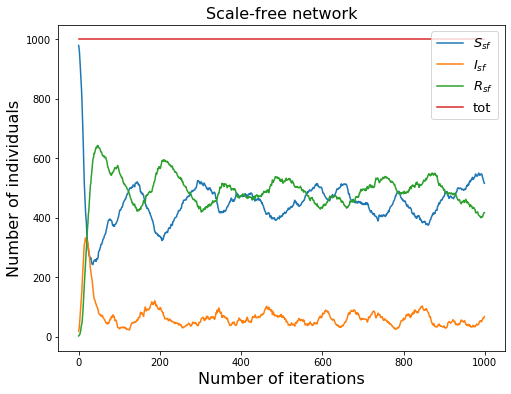

In [31]:
indexes = np.arange(n_iter)
plt.figure(figsize=(8,6))
plt.plot(indexes, S_sf, label = r'$S_{sf}$')
plt.plot(indexes, I_sf, label = r'$I_{sf}$')
plt.plot(indexes, R_sf, label = r'$R_{sf}$')
plt.plot(indexes, S_sf+I_sf+R_sf, label = 'tot')
plt.xlabel('Number of iterations', fontsize = 16)
plt.ylabel('Number of individuals', fontsize = 16)
plt.title("Scale-free network", fontsize = 16)
plt.legend(fontsize=13, loc='upper right')
plt.show()

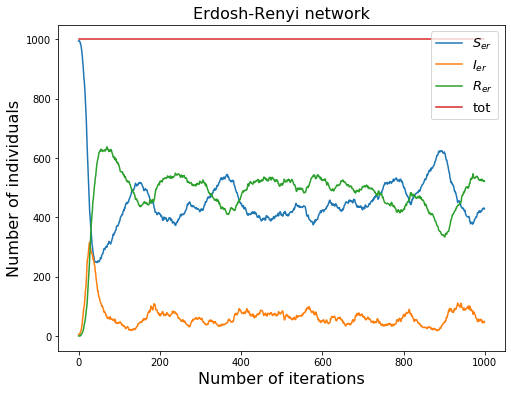

In [32]:
indexes = np.arange(n_iter)
plt.figure(figsize=(8,6))
plt.plot(indexes, S_er, label = r'$S_{er}$')
plt.plot(indexes, I_er, label = r'$I_{er}$')
plt.plot(indexes, R_er, label = r'$R_{er}$')
plt.plot(indexes, S_er+I_er+R_er, label = 'tot')
plt.title("Erdosh-Renyi network", fontsize = 16)
plt.xlabel('Number of iterations', fontsize = 16)
plt.ylabel('Number of individuals', fontsize = 16)
plt.legend(fontsize=13, loc='upper right')
plt.show()

### Time profiling

The objective of this section is to see if there are inefficent parts of the code that can be improved without too much effort.

In [53]:
def two_sys_full_SIRS_step_v1(state_sf, state_er, travellers_sf, travellers_er, new_ids_sf, new_ids_er, 
                           deg_sf, deg_er, A_sf, A_er, G_sf_stay, G_er_stay, beta, mu, gamma):
    """ 
    Simulate a single step of a SIRS dynamics over 2 coupled network with mobility, 
    taking into account the undelying structure of the networks. 
    
    Parameters
    ----------
    state_sf: numpy array of shape (N,3) - state of the scale free network
        state_sf[:,0] = 1 for the susceptible, 0 for the others
        state_sf[:,1] = 1 for the infected, 0 for the others
        state_sf[:,2] = 1 for the recovered, 0 for the others
    state_er: numpy array of shape (N,3) - state of the Erdosh-Renyi network
    **variables_net_sf (see "prepare_two_sys" function description)
    **variables_net_er (see "prepare_two_sys" function description)
    **infection_params (beta, mu, gamma)
    
    Returns
    -------
    state_sf, state_er, (updated)
    time_profile 
    """
    N = len(state_sf)
    Nij = len(travellers_sf)
    N_tot = N + Nij
    
    import time 
    
    ### day ###
    
    t0 = time.time()
    # compute day networks
    _, A_sf_day = attach_travellers(G_sf_stay, new_ids_er, deg_er, N_tot)
    _, A_er_day = attach_travellers(G_er_stay, new_ids_sf, deg_sf, N_tot)
    t1 = time.time()
    
    # mobility masks (True if present, False if travelling)
    mob_mask_sf = (~np.isin(np.arange(N_tot), travellers_sf)).astype(int)
    mob_mask_er = (~np.isin(np.arange(N_tot), travellers_er)).astype(int)
    t2 = time.time()
    
    # states of the travellers
    state_sf_trav = state_sf[travellers_sf]
    state_er_trav = state_er[travellers_er]
    t3 = time.time()
    
    # stay + travellers of the other system state 
    # also absent travellers are virtually present - that is why we use masks
    state_sf_day = np.concatenate((state_sf, state_er_trav))
    state_er_day = np.concatenate((state_er, state_sf_trav))
    t4 = time.time()
    
    # make day SIRS step
    state_sf_day = SIRS_masked_step(A_sf_day, state_sf_day, mob_mask_sf, beta, mu, gamma)
    state_er_day = SIRS_masked_step(A_er_day, state_er_day, mob_mask_er, beta, mu, gamma)
    t5 = time.time()
    
    # extract the state of the travellers
    state_sf_trav = state_er_day[N:] 
    state_er_trav = state_sf_day[N:] 
    t6 = time.time()
    
    # overwrite them into the original system 
    state_sf[travellers_sf] = state_sf_trav
    state_er[travellers_sf] = state_er_trav
    t7 = time.time()
    
    ### night ###
    
    # make SIRS step
    state_sf = SIRS_step(A_sf, state_sf, beta, mu, gamma)
    state_er = SIRS_step(A_er, state_er, beta, mu, gamma)
    t8 = time.time()
    
    time_profile = [t1-t0, t2-t1, t3-t2, t4-t3, t5-t4, t6-t5, t7-t6, t8-t7]
    return state_sf, state_er, time_profile

In [33]:
%%time
state_sf, state_er, time_profile = two_sys_full_SIRS_step_v1(state_sf, state_er, **variables_net_sf, 
                                            **variables_net_er, **infection_params)

CPU times: user 86 ms, sys: 11.8 ms, total: 97.8 ms
Wall time: 88.6 ms


In [34]:
print("Attach travellers time: %.3f ms"%(time_profile[0]*10**3))
print("Compute masks time: %.3f ms"%(time_profile[1]*10**3))
print("Get travellers state time: %.3f ms"%(time_profile[2]*10**3))
print("Concatenate states time: %.3f ms"%(time_profile[3]*10**3))
print("SIRS masked steps time: %.3f ms"%(time_profile[4]*10**3))
print("Get travellers state time: %.3f ms"%(time_profile[5]*10**3))
print("Recompute states time: %.3f ms"%(time_profile[6]*10**3))
print("SIRS step time: %.3f ms"%(time_profile[7]*10**3))

Attach travellers time: 78.267 ms
Compute masks time: 0.442 ms
Get travellers state time: 0.029 ms
Concatenate states time: 0.025 ms
SIRS masked steps time: 4.049 ms
Get travellers state time: 0.005 ms
Recompute states time: 0.021 ms
SIRS step time: 3.498 ms


As can be seen the bottleneck is in the procedure of attaching the travellers to the new network.

In [35]:
def attach_travellers_v1(G_sf_stay, new_ids_er, deg_er, N_tot):
    """
    Attach new travellers using preferential attachment and keeping their original degrees.
    
    Parameters
    ----------
    G_sf_stay : networkx Graph instance, graph of the nodes that do not travel
    new_ids_er :  dict, contains the pairs {'new_id_er':old_id}
    deg_er :  numpy array of int, contains the degrees of all the travelling nodes from the ER network
    N_tot : int, number of original nodes + travelling nodes
    
    Returns
    -------
    G_sf_day :  networkx Graph instance, graph of the nodes that stay in the SF system 
                + those that come from the ER network
    A_sf_day : numpy matrix, adjacency matrix of G_sf_day 
    """
    import time
    
    t0 = time.time()
    edge_list_sf = list(G_sf_stay.edges)
    t1 = time.time()
    for i,ID in enumerate(new_ids_er.keys()):
        k = deg_er[i]
        indexes = np.random.choice(len(edge_list_sf), size=k, replace=False)
        edges = [(ID,np.random.choice(list(edge_list_sf[j]))) for j in indexes]
        edge_list_sf += edges # concatenate new edges
        #for j in indexes:
        #    trg = np.random.choice(list(edge_list_sf[j]))
        #    edge_list_sf.append((ID,trg))
    t2 = time.time()        
    G_sf_day = nx.Graph(edge_list_sf)
    t3 = time.time()
    # add also the nodes without edges to get the known dimension N_tot
    G_sf_day.add_nodes_from(np.arange(N_tot))
    t4 = time.time()
    A_sf_day = nx.to_numpy_matrix(G_sf_day, nodelist=np.arange(N_tot))
    t5 = time.time()
    
    time_profile = [t1-t0, t2-t1, t3-t2, t4-t3, t5-t4]
    return G_sf_day, A_sf_day, time_profile

In [50]:
%%timeit
_, A_sf_day, time_profile1 = attach_travellers_v1(G_sf_stay , new_ids_er, deg_er, N_tot)

25.5 ms ± 961 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [41]:
print("Get list of edges time: %.3f ms"%(time_profile1[0]*10**3))
print("Append new edges time: %.3f ms"%(time_profile1[1]*10**3))
print("Create new graph time: %.3f ms"%(time_profile1[2]*10**3))
print("Add missing nodes time: %.3f ms"%(time_profile1[3]*10**3))
print("Get adjacency matrix time: %.3f ms"%(time_profile1[4]*10**3))

Get list of edges time: 1.621 ms
Append new edges time: 17.954 ms
Create new graph time: 3.989 ms
Add missing nodes time: 1.048 ms
Get adjacency matrix time: 11.340 ms


The time gets spent in two different parts: adding the new edges to the list of edges and creating the adjacency matrix. We can take a shortcut in creating the matrix directly with numpy as follows:

In [48]:
%%time
edge_list_sf = list(G_sf_stay.edges)
A = np.zeros((N_tot,N_tot)) 
edge_list_sf = np.array(edge_list_sf)
x = edge_list_sf[:,0]
y = edge_list_sf[:,1]
A[x,y] = 1
A[y,x] = 1
print(len(edge_list_sf))
print(A.sum())

1750
3500.0
CPU times: user 9.87 ms, sys: 168 µs, total: 10 ms
Wall time: 6.83 ms


On average this results in being twice as fast (13 ms vs 25.5ms).

In [52]:
def attach_travellers_v2(G_sf_stay, new_ids_er, deg_er, N_tot):
    """
    Attach new travellers using preferential attachment and keeping their original degrees.
    
    Parameters
    ----------
    G_sf_stay : networkx Graph instance, graph of the nodes that do not travel
    new_ids_er :  dict, contains the pairs {'new_id_er':old_id}
    deg_er :  numpy array of int, contains the degrees of all the travelling nodes from the ER network
    N_tot : int, number of original nodes + travelling nodes
    
    Returns
    -------
    A_sf_day : numpy matrix, adjacency matrix of G_sf_day 
    """
    import time
    
    t0 = time.time()
    edge_list_sf = list(G_sf_stay.edges)
    t1 = time.time()
    for i,ID in enumerate(new_ids_er.keys()):
        k = deg_er[i]
        indexes = np.random.choice(len(edge_list_sf), size=k, replace=False)
        edges = [(ID,np.random.choice(list(edge_list_sf[j]))) for j in indexes]
        edge_list_sf += edges # concatenate new edges
    t2 = time.time() 
    edge_list_sf = np.array(edge_list_sf)
    x = edge_list_sf[:,0]
    y = edge_list_sf[:,1]
    A_sf_day = np.zeros((N_tot,N_tot)) 
    A_sf_day[x,y] = 1
    A_sf_day[y,x] = 1     
    t3 = time.time() 
    
    time_profile = [t1-t0, t2-t1, t3-t2]
    return A_sf_day, time_profile

In [49]:
%%timeit
A_sf_day, time_profile2 = attach_travellers_v2(G_sf_stay , new_ids_er, deg_er, N_tot)

13 ms ± 292 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [51]:
print("Get list of edges time: %.3f ms"%(time_profile2[0]*10**3))
print("Append new edges time: %.3f ms"%(time_profile2[1]*10**3))
print("Get adjacency matrix time: %.3f ms"%(time_profile2[2]*10**3))

Get list of edges time: 1.936 ms
Append new edges time: 16.329 ms
Get adjacency matrix time: 4.868 ms
